# Health Care Fraud Detection 

## Part I. Exploratory Data Analysis 

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

from datetime import datetime

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns


In [2]:
df_ip = pd.read_csv('../../../raw_data/Train_Inpatientdata-1542865627584.csv')

df_op = pd.read_csv('../../../raw_data/Train_Outpatientdata-1542865627584.csv')

df_p = pd.read_csv('../../../raw_data/Train_Beneficiarydata-1542865627584.csv')

flags = pd.read_csv('../../../raw_data/Train-1542865627584.csv')




In [3]:
df_ip_test = pd.read_csv('../../../raw_data/Test_Inpatientdata-1542969243754.csv')

df_op_test = pd.read_csv('../../../raw_data/Test_Outpatientdata-1542969243754.csv')

df_p_test = pd.read_csv('../../../raw_data/Test_Beneficiarydata-1542969243754.csv')

test = pd.read_csv('../../../raw_data/Test-1542969243754.csv')

### Preliminary analysis of the datasets

In [4]:
print ('Shape of the train IP dataset: ', df_ip.shape)
print ('Shape of the train OP dataset: ',df_op.shape)
print ('Shape of the train Patients dataset: ', df_p.shape)
print ('Shape of the train Flags dataset: ', flags.shape)

Shape of the train IP dataset:  (40474, 30)
Shape of the train OP dataset:  (517737, 27)
Shape of the train Patients dataset:  (138556, 25)
Shape of the train Flags dataset:  (5410, 2)


In [5]:
print ('Shape of the test IP dataset: ', df_ip_test.shape)
print ('Shape of the test OP dataset: ',df_op_test.shape)
print ('Shape of the test Patients dataset: ', df_p_test.shape)
print ('Shape of the test No Flags dataset: ', test.shape)

Shape of the test IP dataset:  (9551, 30)
Shape of the test OP dataset:  (125841, 27)
Shape of the test Patients dataset:  (63968, 25)
Shape of the test No Flags dataset:  (1353, 1)


In [6]:
print ('ClaimStartDt in train IP dataset range from ', \
      min(df_ip['ClaimStartDt']), 'to ', max(df_ip['ClaimStartDt']))
print ('ClaimStartDt in train OP dataset range from ', \
      min(df_op['ClaimStartDt']), 'to ', max(df_op['ClaimStartDt']))
print ('ClaimStartDt in test IP dataset range from ', \
      min(df_ip_test['ClaimStartDt']), 'to ', max(df_ip_test['ClaimStartDt']))
print ('ClaimStartDt in test OP dataset range from ', \
      min(df_op_test['ClaimStartDt']), 'to ', max(df_op_test['ClaimStartDt']))

ClaimStartDt in train IP dataset range from  2008-11-27 to  2009-12-31
ClaimStartDt in train OP dataset range from  2008-12-12 to  2009-12-31
ClaimStartDt in test IP dataset range from  2008-11-27 to  2009-12-31
ClaimStartDt in test OP dataset range from  2008-12-12 to  2009-12-31


Let's have a closer look at the flag dataset - for each provider in inpatient and outpatient train datasets, it says whether or not it is flagged as a potential fraud. 

In [7]:
flags['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

In [8]:
print('The number of providers flagged as potential fraud providers is ',\
     sum(flags['PotentialFraud']=='Yes'))

print('The number of providers flagged as no fraud providers is ',\
     sum(flags['PotentialFraud']=='No'))

The number of providers flagged as potential fraud providers is  506
The number of providers flagged as no fraud providers is  4904


In [9]:
print(flags[flags == 'Yes'].count(axis = 0)/len(flags.index))

Provider          0.00000
PotentialFraud    0.09353
dtype: float64


## Warmup Question 1: 

1. How many medical doctors are there in the train outpatient dataset?

In [10]:
print('The number of attending physicians in the train OP: ', \
      df_op['AttendingPhysician'].nunique())
print('The number of operating physicians in the train OP: ', \
      df_op['OperatingPhysician'].nunique())
print('The number of extra physicians in the train OP: ', \
      df_op['OtherPhysician'].nunique())

The number of attending physicians in the train OP:  74109
The number of operating physicians in the train OP:  28532
The number of extra physicians in the train OP:  44388


2. How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?

In [11]:
print('The number of attending physicians in the train IP: ', \
      df_ip['AttendingPhysician'].nunique())
print('The number of operating physicians in the train IP: ', \
      df_ip['OperatingPhysician'].nunique())
print('The number of extra physicians in the train IP: ', \
      df_ip['OtherPhysician'].nunique())

The number of attending physicians in the train IP:  11604
The number of operating physicians in the train IP:  8287
The number of extra physicians in the train IP:  2877


In [12]:
df_op['AttendingPhysician'].describe()

count        516341
unique        74109
top       PHY330576
freq           2534
Name: AttendingPhysician, dtype: object

In [13]:
df_ip['AttendingPhysician'].describe()

count         40362
unique        11604
top       PHY422134
freq            386
Name: AttendingPhysician, dtype: object

In [14]:
df_op['OperatingPhysician'].describe()

count         90617
unique        28532
top       PHY330576
freq            424
Name: OperatingPhysician, dtype: object

In [15]:
df_ip['OperatingPhysician'].describe()

count         23830
unique         8287
top       PHY429430
freq            225
Name: OperatingPhysician, dtype: object

In [16]:
df_op['OtherPhysician'].describe()

count        195046
unique        44388
top       PHY412132
freq           1247
Name: OtherPhysician, dtype: object

In [17]:
df_ip['OtherPhysician'].describe()

count          4690
unique         2877
top       PHY416093
freq             81
Name: OtherPhysician, dtype: object

3. Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients, or do those who have more visits to the providers have worse health conditions? Provide an analysis on these issues.

In [18]:
(df_ip.isnull().sum()*100/len(df_ip)).sort_values(ascending = False)

ClmProcedureCode_6        100.000000
ClmProcedureCode_5         99.977764
ClmProcedureCode_4         99.713396
ClmProcedureCode_3         97.615753
ClmDiagnosisCode_10        90.297475
OtherPhysician             88.412314
ClmProcedureCode_2         86.524683
ClmProcedureCode_1         42.807728
OperatingPhysician         41.122696
ClmDiagnosisCode_9         33.347334
ClmDiagnosisCode_8         24.563918
ClmDiagnosisCode_7         17.932500
ClmDiagnosisCode_6         11.953353
ClmDiagnosisCode_5          7.150269
ClmDiagnosisCode_4          3.790087
DeductibleAmtPaid           2.221179
ClmDiagnosisCode_3          1.670208
ClmDiagnosisCode_2          0.558383
AttendingPhysician          0.276721
ClaimID                     0.000000
ClaimStartDt                0.000000
ClaimEndDt                  0.000000
Provider                    0.000000
InscClaimAmtReimbursed      0.000000
ClmDiagnosisCode_1          0.000000
AdmissionDt                 0.000000
ClmAdmitDiagnosisCode       0.000000
D

In [19]:
(df_op.isnull().sum()*100/len(df_op)).sort_values(ascending = False)

ClmProcedureCode_6        100.000000
ClmProcedureCode_5        100.000000
ClmProcedureCode_4         99.999614
ClmProcedureCode_3         99.999227
ClmProcedureCode_2         99.993047
ClmProcedureCode_1         99.968710
ClmDiagnosisCode_10        99.790820
ClmDiagnosisCode_9         97.134066
ClmDiagnosisCode_8         95.574587
ClmDiagnosisCode_7         93.633640
ClmDiagnosisCode_6         90.582864
ClmDiagnosisCode_5         85.640586
OperatingPhysician         82.497484
ClmAdmitDiagnosisCode      79.637345
ClmDiagnosisCode_4         75.741351
OtherPhysician             62.327205
ClmDiagnosisCode_3         60.741264
ClmDiagnosisCode_2         37.737307
ClmDiagnosisCode_1          2.018979
AttendingPhysician          0.269635
DeductibleAmtPaid           0.000000
InscClaimAmtReimbursed      0.000000
Provider                    0.000000
ClaimEndDt                  0.000000
ClaimStartDt                0.000000
ClaimID                     0.000000
BeneID                      0.000000
d

Comparing the values for Claim Diagnosis Codes from 1 to 10, we observe that inpatient patients have more diseases than outpatients. 

4. How many distinct patients (BeneIDs) are there in the in/out-patient datasets?

In [20]:
print('The number of distinct patients in the train IP dataset: ', \
     df_ip['BeneID'].nunique())
print('The number of distinct patients in the train OP dataset: ', \
     df_op['BeneID'].nunique())
print('The number of distinct patients in the test IP dataset: ', \
     df_ip_test['BeneID'].nunique())
print('The number of distinct patients in the test IP dataset: ', \
     df_op_test['BeneID'].nunique())

The number of distinct patients in the train IP dataset:  31289
The number of distinct patients in the train OP dataset:  133980
The number of distinct patients in the test IP dataset:  8351
The number of distinct patients in the test IP dataset:  59608


5. Do doctors serve for different providers? Study the distribution of hospital counts/doctor? Is it possible to characterize those doctors who move around among different providers?

In [21]:
df_ip.groupby('AttendingPhysician')['Provider'].nunique().sort_values(ascending = False)

AttendingPhysician
PHY395862    3
PHY423850    3
PHY359004    3
PHY386600    3
PHY421048    3
            ..
PHY393107    1
PHY393087    1
PHY393075    1
PHY393072    1
PHY311002    1
Name: Provider, Length: 11604, dtype: int64

In [22]:
df_ip.groupby('AttendingPhysician')['Provider'].nunique().value_counts()

1    11409
2      190
3        5
Name: Provider, dtype: int64

In [23]:
df_op.groupby('AttendingPhysician')['Provider'].nunique().sort_values(ascending = False)

AttendingPhysician
PHY365132    8
PHY342165    8
PHY417254    7
PHY332314    6
PHY389249    6
            ..
PHY391679    1
PHY391678    1
PHY391677    1
PHY391675    1
PHY311001    1
Name: Provider, Length: 74109, dtype: int64

In [24]:
df_op.groupby('AttendingPhysician')['Provider'].nunique().value_counts()

1    69523
2     4145
3      349
4       63
5       18
6        8
8        2
7        1
Name: Provider, dtype: int64

Clearly, there are many more doctors on the OP dataset that serve more than one provider than those on the IP dataset. 

6. Do patients go to different hospitals? Study the distribution of hospital counts/patient? It is possible to characterize those patients who receive services from a lot of different hospitals?

In [25]:
df_ip.groupby('BeneID')['Provider'].nunique().sort_values(ascending = False)

BeneID
BENE49263     5
BENE63935     5
BENE83032     5
BENE55497     5
BENE152105    5
             ..
BENE46939     1
BENE46956     1
BENE46971     1
BENE46975     1
BENE100002    1
Name: Provider, Length: 31289, dtype: int64

In [26]:
df_ip.groupby('BeneID')['Provider'].nunique().value_counts()

1    26694
2     3965
3      541
4       76
5       13
Name: Provider, dtype: int64

In [27]:
df_op.groupby('BeneID')['Provider'].nunique().sort_values(ascending = False)

BeneID
BENE40202     19
BENE122143    17
BENE122118    16
BENE120090    16
BENE140999    16
              ..
BENE16458      1
BENE16456      1
BENE16455      1
BENE16450      1
BENE100000     1
Name: Provider, Length: 133980, dtype: int64

In [28]:
df_op.groupby('BeneID')['Provider'].nunique().value_counts()

1     49671
2     34432
3     21370
4     12646
5      7168
6      3992
7      2277
8      1192
9       610
10      288
11      177
12       89
13       39
14       12
15       11
16        4
17        1
19        1
Name: Provider, dtype: int64

7. Do the same providers provide both inpatient and outpatient services? Summarize your finding.

In [29]:
#not correct
df_ip['Provider'].isin(df_op['Provider']).value_counts()

True     36727
False     3747
Name: Provider, dtype: int64

In [30]:
len(set(df_op.Provider.to_list()).intersection(set(df_ip.Provider.to_list())))

1694

8. Do Some of the same patients receive both inpatient and outpatient services? Summarize your finding.

In [31]:
#not correct
df_ip['BeneID'].isin(df_op['BeneID']).value_counts()

True     35043
False     5431
Name: BeneID, dtype: int64

In [32]:
len(set(df_op.BeneID.to_list()).intersection(set(df_ip.BeneID.to_list())))

26713

## Warmup Question 4:

1. Study the distributions of InscClaimAmtReimbursed, DeductibleAmtPaid for both inpatient and outpatient services. Your team might want to work with hist, scatter or sns.pairplot, distplot, etc.

In [33]:
df_ip['InscClaimAmtReimbursed'].describe()

count     40474.000000
mean      10087.884074
std       10303.099402
min           0.000000
25%        4000.000000
50%        7000.000000
75%       12000.000000
max      125000.000000
Name: InscClaimAmtReimbursed, dtype: float64

In [34]:
df_ip['InscClaimAmtReimbursed'].mode()

0    4000
dtype: int64

In [35]:
df_ip['DeductibleAmtPaid'].describe()

count    39575.0
mean      1068.0
std          0.0
min       1068.0
25%       1068.0
50%       1068.0
75%       1068.0
max       1068.0
Name: DeductibleAmtPaid, dtype: float64

In [36]:
df_op['InscClaimAmtReimbursed'].describe()

count    517737.000000
mean        286.334799
std         694.034343
min           0.000000
25%          40.000000
50%          80.000000
75%         200.000000
max      102500.000000
Name: InscClaimAmtReimbursed, dtype: float64

In [37]:
df_op['DeductibleAmtPaid'].describe()

count    517737.000000
mean          2.779233
std          15.785839
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         897.000000
Name: DeductibleAmtPaid, dtype: float64

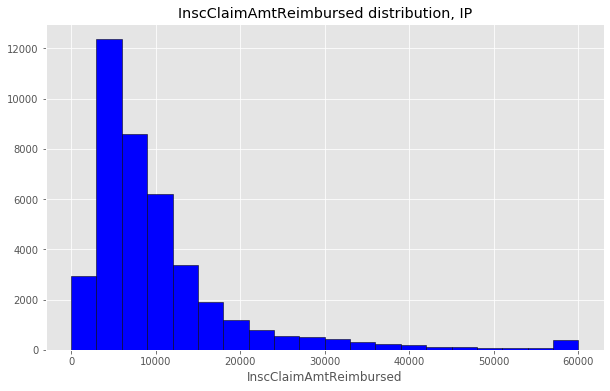

In [38]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_ip.InscClaimAmtReimbursed, bins = 20, range =[0,60000], \
         facecolor = 'b', edgecolor = 'k')
plt.xlabel('InscClaimAmtReimbursed')
plt.title('InscClaimAmtReimbursed distribution, IP')
plt.show()

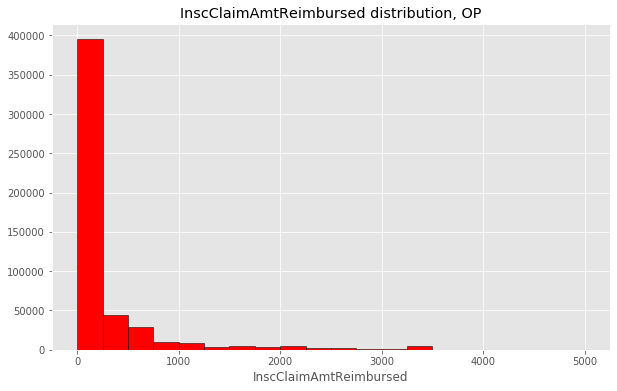

In [39]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_op.InscClaimAmtReimbursed, bins = 20, range =[0,5000], \
         facecolor = 'r', edgecolor = 'k')
plt.xlabel('InscClaimAmtReimbursed')
plt.title('InscClaimAmtReimbursed distribution, OP')
plt.show()

2. Study the distributions of insurance covered percentages InscClaimAmtReimbursed/(InscClaimAmtReimbursed+DeductibleAmtPaid).

In [40]:
df_ip['InscCoveredPerc'] = df_ip['InscClaimAmtReimbursed']/(df_ip['InscClaimAmtReimbursed'] + \
                                                           df_ip['DeductibleAmtPaid'])
df_ip['InscCoveredPerc'].round(2)

0        0.96
1        0.82
2        0.82
3        0.82
4        0.90
         ... 
40469    0.87
40470    0.79
40471    0.74
40472    0.82
40473    0.93
Name: InscCoveredPerc, Length: 40474, dtype: float64

In [41]:
df_ip['InscCoveredPerc'].describe()

count    39575.000000
mean         0.829798
std          0.167507
min          0.000000
25%          0.789266
50%          0.867625
75%          0.918274
max          0.991528
Name: InscCoveredPerc, dtype: float64

/Users/ElinaMac/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ElinaMac/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


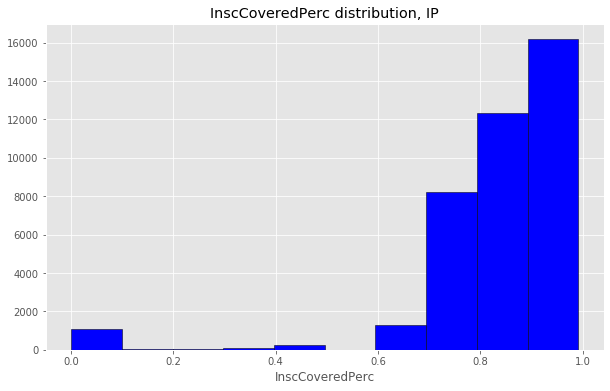

In [42]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_ip.InscCoveredPerc, facecolor = 'b', edgecolor = 'k')
plt.xlabel('InscCoveredPerc')
plt.title('InscCoveredPerc distribution, IP')
plt.show()

In [43]:
df_op['InscCoveredPerc'] = df_op['InscClaimAmtReimbursed']/(df_op['InscClaimAmtReimbursed'] + \
                                                           df_op['DeductibleAmtPaid'])

In [44]:
df_op['InscCoveredPerc'].round(2)

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
517732    1.0
517733    1.0
517734    1.0
517735    1.0
517736    1.0
Name: InscCoveredPerc, Length: 517737, dtype: float64

In [45]:
df_op['InscCoveredPerc'].describe()

count    499072.000000
mean          0.982011
std           0.101637
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: InscCoveredPerc, dtype: float64

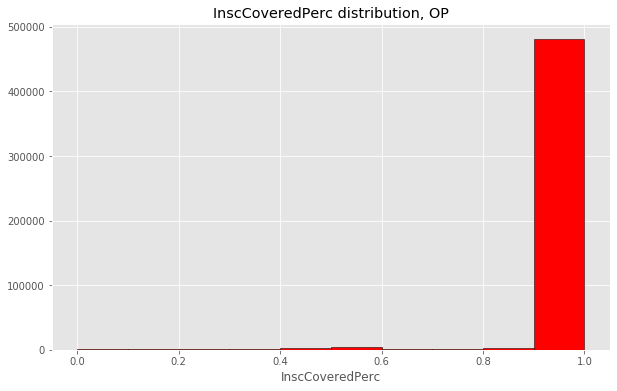

In [46]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_op.InscCoveredPerc, facecolor = 'r', edgecolor = 'k')
plt.xlabel('InscCoveredPerc')
plt.title('InscCoveredPerc distribution, OP')
plt.show()

3. Study the distributions of the durations of average insurance claims (end-start) of the providers? Box-plot/violin-plot based on the PotentialFraud flag. Do you find any differences for none-potential fraud vs potential-fraud providers?

In [47]:
fmt = '%Y-%m-%d'

df_ip['ClaimStartDt'] = pd.to_datetime(df_ip['ClaimStartDt'], format = '%Y-%m-%d')
df_ip['ClaimEndDt'] = pd.to_datetime(df_ip['ClaimEndDt'], format = '%Y-%m-%d')

df_op['ClaimStartDt'] = pd.to_datetime(df_op['ClaimStartDt'], format = '%Y-%m-%d')
df_op['ClaimEndDt'] = pd.to_datetime(df_op['ClaimEndDt'], format = '%Y-%m-%d')

In [48]:
df_ip['Duration'] = df_ip['ClaimEndDt'] - df_ip['ClaimStartDt']

df_ip['Duration'] = df_ip['Duration']/np.timedelta64(1, 'D')

In [49]:
df_op['Duration'] = df_op['ClaimEndDt'] - df_op['ClaimStartDt']

df_op['Duration'] = df_op['Duration']/np.timedelta64(1, 'D')

In [50]:
df_ip.groupby('Provider')['Duration'].mean().sort_values(ascending = False)

Provider
PRV57080    35.000000
PRV56179    33.000000
PRV53449    28.000000
PRV55213    26.666667
PRV53431    24.000000
              ...    
PRV56908     0.000000
PRV56242     0.000000
PRV53471     0.000000
PRV56485     0.000000
PRV54668     0.000000
Name: Duration, Length: 2092, dtype: float64

In [51]:
df_op.groupby('Provider')['Duration'].mean().sort_values(ascending = False)

Provider
PRV54046    20.0
PRV55637    20.0
PRV57758    20.0
PRV51577    20.0
PRV56677    14.0
            ... 
PRV51993     0.0
PRV55501     0.0
PRV56891     0.0
PRV51987     0.0
PRV56115     0.0
Name: Duration, Length: 5012, dtype: float64

We create two dataframes - for inpatients and outpatient beneficiaries, with added flags for each provider. 

In [52]:
df_ip_flags = pd.merge(df_ip, flags, on = 'Provider')
df_op_flags = pd.merge(df_op, flags, on = 'Provider')

From each of these dataframes, we make two separate dataframes, each containing only providers with or without potential fraud flag. 

In [53]:
df_ip_fraud = df_ip_flags[df_ip_flags['PotentialFraud'] == 'Yes']
df_op_fraud = df_op_flags[df_op_flags['PotentialFraud'] == 'Yes']
df_ip_nfraud = df_ip_flags[df_ip_flags['PotentialFraud'] == 'No']
df_op_nfraud = df_op_flags[df_op_flags['PotentialFraud'] == 'No']

In [54]:
df_fraud = pd.concat([df_ip_fraud, df_op_fraud])
df_nfraud = pd.concat([df_ip_nfraud, df_op_nfraud])

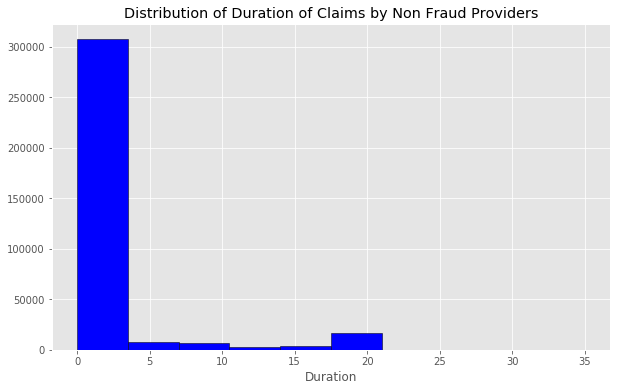

In [55]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_nfraud.Duration, facecolor = 'b', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Duration of Claims by Non Fraud Providers')
plt.show()

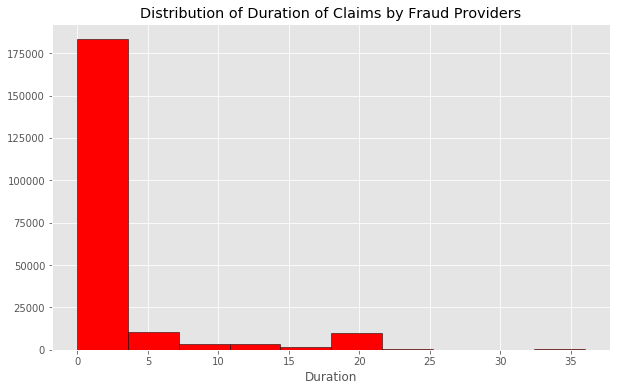

In [56]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_fraud.Duration, facecolor = 'r', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Duration of Claims by Fraud Providers')
plt.show()

In [57]:
AvgDuration = df_ip_fraud.groupby('Provider')['Duration'].mean()

In [58]:
AvgDuration = AvgDuration.to_frame()

In [59]:
df = pd.concat([df_ip_flags, df_op_flags])

In [60]:
df['ip_op'] = df.PotentialFraud.apply(lambda x: 1 if x == 'Yes' else 0)

In [61]:
df.shape

(558211, 34)

In [62]:
df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,InscCoveredPerc,Duration,PotentialFraud,ip_op
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,NaN,NaN,NaN,NaN,NaN,NaN,0.960544,6.0,Yes,1
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,7769.0,5849.0,NaN,NaN,NaN,NaN,0.946781,12.0,Yes,1
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,9338.0,NaN,NaN,NaN,NaN,NaN,0.940890,18.0,Yes,1
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,8154.0,NaN,NaN,NaN,NaN,NaN,0.924083,4.0,Yes,1
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,...,8543.0,NaN,NaN,NaN,NaN,NaN,0.737463,4.0,Yes,1


In [63]:
AvgDur = df.groupby('Provider')['Duration'].mean()

In [64]:
AvgDur.shape

(5410,)

In [65]:
df_flags = flags.copy()

## Introducing the Final Dataset

In [66]:
data = pd.merge(df_flags, AvgDur, on ='Provider')

In [67]:
data.shape

(5410, 3)

In [68]:
data.columns

Index(['Provider', 'PotentialFraud', 'Duration'], dtype='object')

In [69]:
data.Duration.describe()

count    5410.000000
mean        2.013987
std         2.057721
min         0.000000
25%         0.875000
50%         1.586207
75%         2.544613
max        35.000000
Name: Duration, dtype: float64

In [88]:
#this is a test for github

In [70]:
my_palette = {'No': 'b', 'Yes': 'r'}

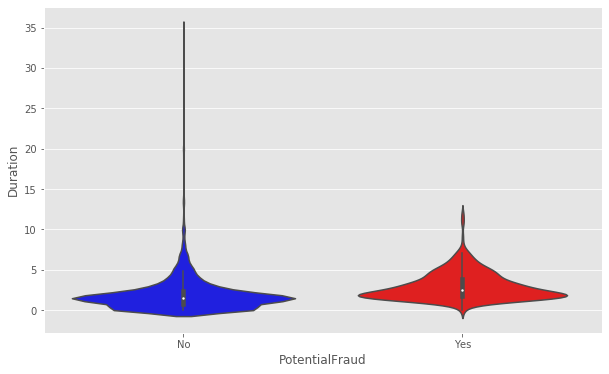

In [71]:
fig, ax = plt.subplots(figsize =(10, 6)) 
ax = sns.violinplot(x="PotentialFraud", y="Duration", data=data, palette = my_palette)

In [72]:
df_fraud = pd.concat([df_ip_fraud, df_op_fraud])
df_nfraud = pd.concat([df_ip_nfraud, df_op_nfraud])

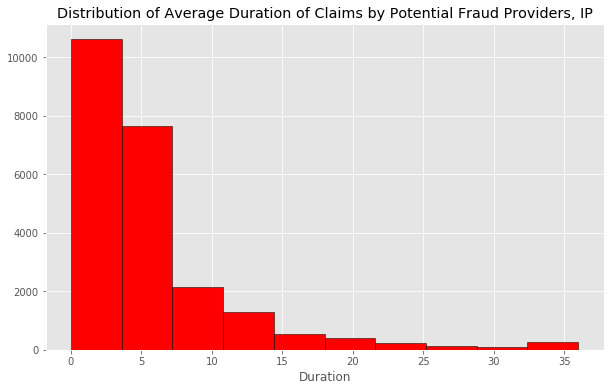

In [73]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_ip_fraud.Duration, facecolor = 'r', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Average Duration of Claims by Potential Fraud Providers, IP')
plt.show()

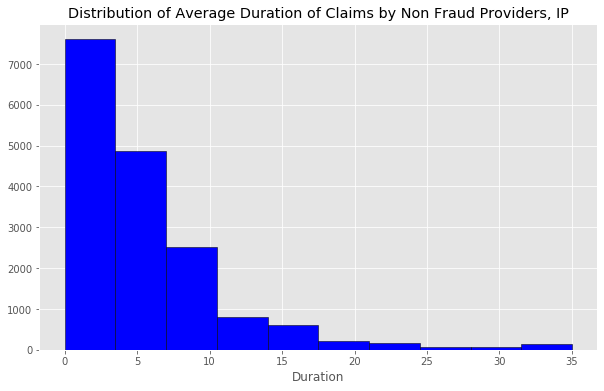

In [74]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_ip_nfraud.Duration, facecolor = 'b', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Average Duration of Claims by Non Fraud Providers, IP')
plt.show()

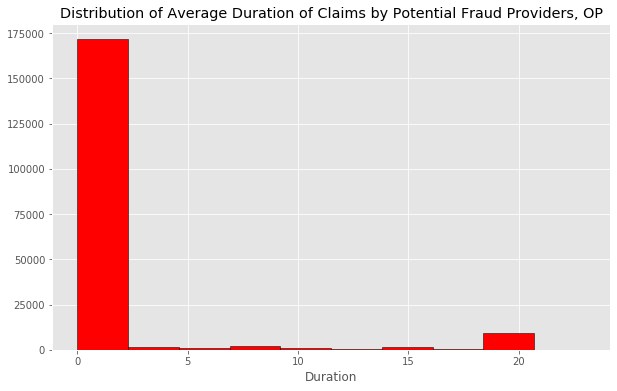

In [75]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_op_fraud.Duration, facecolor = 'r', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Average Duration of Claims by Potential Fraud Providers, OP')
plt.show()

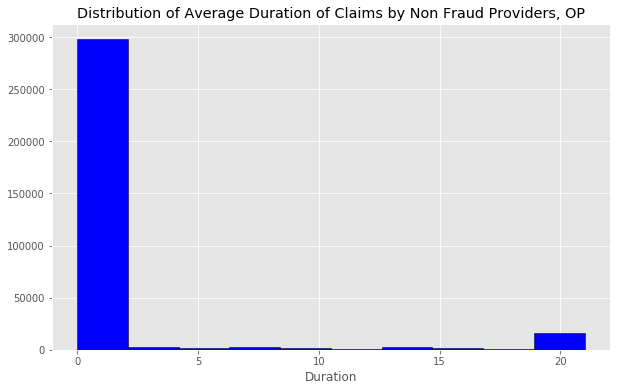

In [76]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_op_nfraud.Duration, facecolor = 'b', edgecolor = 'k')
plt.xlabel('Duration')
plt.title('Distribution of Average Duration of Claims by Non Fraud Providers, OP')
plt.show()

4. How are the service durations related to the total claim amounts, i.e. InscClaimAmtReimbursed+DeductibleAmtPaid?

In [77]:
df['DeductibleAmtPaid'] = df['DeductibleAmtPaid'].fillna(0)

In [78]:
df['TotalClaim'] = df['InscClaimAmtReimbursed'] + df['DeductibleAmtPaid']

In [79]:
AvgClm = df.groupby('Provider')['TotalClaim'].mean()

In [80]:
AvgClm = AvgClm.to_frame()

In [81]:
data = pd.merge(data, AvgClm, on = 'Provider')

In [82]:
data.columns

Index(['Provider', 'PotentialFraud', 'Duration', 'TotalClaim'], dtype='object')

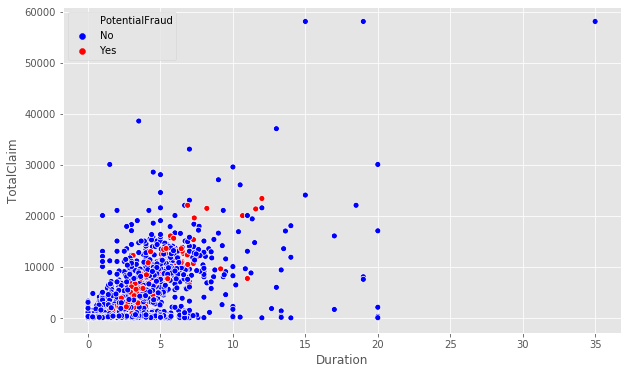

In [83]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Duration', y = 'TotalClaim', hue = 'PotentialFraud',\
               data = data, palette = my_palette)

In [84]:
#data['Duration'] = data['Duration'].round(2)
#data['TotalClaim'] = data['TotalClaim'].round(2)
#data['DailyTotalClaim'] = data['DailyTotalClaim'].round(2)

In [85]:
#data.rename({'Duration': 'AvgDuration', 'TotalClaim': 'AvgTotalClm', \
#            'DailyTotalClaim': 'MeanDailyTotalChrgs'}, \
#            axis = 1, inplace = True)

In [86]:
#fig, ax = plt.subplots(figsize =(10, 6)) 
#ax = sns.violinplot(x="PotentialFraud", y="MeanDailyTotalChrgs", \
#                    data=data, palette = my_palette)